Imports

In [2]:
# Standard library imports
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests


### Carsales

extracted from https://opendata.cbs.nl/#/CBS/nl/dataset/85898NED/table?ts=1745764299955

>Dataset inladen 

In [3]:
# Autoverkoop inladen
df_wegvoertuigenRaw = pd.read_csv(
    r"E:\Nieuw dataset\Verkochte wegvoertuigen\Verkochte_wegvoertuigen_Full elektric.csv",
    sep=";"
)

display(df_wegvoertuigenRaw)

,Wegvoertuigen,Brandstofsoort voertuig,Perioden,Totaal verkochte wegvoertuigen (aantal)
0,Totaal wegvoertuigen,Full elektric (BEV),2007 januari,31
1,Totaal wegvoertuigen,Full elektric (BEV),2007 februari,39
2,Totaal wegvoertuigen,Full elektric (BEV),2007 maart,123
3,Totaal wegvoertuigen,Full elektric (BEV),2007 april,62
4,Totaal wegvoertuigen,Full elektric (BEV),2007 mei,84
...,...,...,...,...
214,Totaal wegvoertuigen,Full elektric (BEV),2024 november*,32623
215,Totaal wegvoertuigen,Full elektric (BEV),2024 december*,39594
216,Totaal wegvoertuigen,Full elektric (BEV),2025 januari*,33680
217,Totaal wegvoertuigen,Full elektric (BEV),2025 februari*,29071


>Data opschonen en transformeren: Nederlandse naar Engelse maanden, periode-format, filtering, Mapping van Nederlandse naar Engelse maandnamen

In [4]:
maand_mapping = {
    'januari': 'January',
    'februari': 'February',
    'maart': 'March',
    'april': 'April',
    'mei': 'May',
    'juni': 'June',
    'juli': 'July',
    'augustus': 'August',
    'september': 'September',
    'oktober': 'October',
    'november': 'November',
    'december': 'December'
}

# 1. Sterretjes verwijderen
df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace('*', '', regex=False).str.strip()

# 2. Nederlandse maandnamen vervangen door Engelse
for nl, eng in maand_mapping.items():
    df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace(nl, eng, regex=False)

# 3. Periode omzetten naar datetime
df_wegvoertuigenRaw['Periode'] = pd.to_datetime(df_wegvoertuigenRaw['Perioden'], format='%Y %B', errors='coerce')

# 4. Omzetten naar YYYY/MM string
df_wegvoertuigenRaw['Periode'] = df_wegvoertuigenRaw['Periode'].dt.strftime('%Y/%m')

# 5. Alleen relevante kolommen behouden
df_wegvoertuigen = df_wegvoertuigenRaw[['Periode', 'Totaal verkochte wegvoertuigen (aantal)']]

# 5b. Filter op periode 2015/01 t/m 2025/03
df_wegvoertuigen = df_wegvoertuigen[
    (df_wegvoertuigen['Periode'] >= '2007/01') & 
    (df_wegvoertuigen['Periode'] <= '2025/03')
]

# 6. Kolom hernoemen
df_wegvoertuigen.rename(columns={'Totaal verkochte wegvoertuigen (aantal)': 'Totaal_verkochte_wegvoertuigen'}, inplace=True)

# 7. Resultaat bekijken
display(df_wegvoertuigen)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007/01,31
1,2007/02,39
2,2007/03,123
3,2007/04,62
4,2007/05,84
...,...,...
214,2024/11,32623
215,2024/12,39594
216,2025/01,33680
217,2025/02,29071


> Opslaan als CSV

In [42]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv"
df_wegvoertuigen.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv


## Google trends:

extracted from https://trends.google.com/trends/explore?cat=47&date=all&geo=NL&q=EV,subsidie%20elektrische%20auto,elektrische%20auto,elektrisch%20rijden

In [3]:
# Autoverkoop inladen
df_trends_Raw = pd.read_csv(
    r"E:\Nieuw dataset\Google trends\samengevoegde_trends.csv",
    sep=","
)

display(df_trends_Raw)

,Date,vraag naar elektrische voertuigen_x,elektrische bussen_x,laadpunten,laadstations,vraag naar elektrische voertuigen_y,uitrol van elektrische voertuigen_x,elektrische bus_x,elektrische bussen_y,plug-in hybride,...,voertuig met verbrandingsmotor,voertuigen met verbrandingsmotor,laders voor lichte voertuigen,wereldwijde elektrische voertuigen,wereldwijde data over elektrische voertuigen,laadnetwerk,thuis opladen,hybride elektrisch,laadpunt,elektrische bus_y
0,2007-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2007-05,0,0,0,0,0,0,28,0,0,...,0,0,0,0,0,0,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024-09,0,0,63,70,0,100,40,0,100,...,0,0,0,0,0,0,57,59,82,40
213,2024-10,0,85,48,62,0,0,69,85,85,...,0,0,0,0,0,0,79,63,71,69
214,2024-11,0,0,47,63,0,0,42,0,57,...,0,0,0,0,0,0,68,46,71,42
215,2024-12,0,82,48,52,0,0,45,82,79,...,0,0,0,0,0,0,69,60,72,45


### Top 3 Corrolerende zoektermen 

In [4]:
df_trends_selected = df_trends_Raw[['Date', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']]
display(df_trends_selected.head())

,Date,thuis opladen,elektrische auto,hybride elektrisch
0,2007-01,0,1,0
1,2007-02,0,0,0
2,2007-03,0,0,0
3,2007-04,0,0,0
4,2007-05,0,2,0


In [5]:

# 6. Kolom hernoemen
df_trends_Raw.rename(columns={'Date': 'Periode'}, inplace=True)


df_trends_Raw['Periode'] = pd.to_datetime(df_trends_Raw['Periode'], format='%Y-%m', errors='coerce')
df_trends_Raw['Periode'] = df_trends_Raw['Periode'].dt.strftime('%Y/%m')



# 5b. Filter op periode 2007/01 t/m 2025/03
df_trends_Raw = df_trends_Raw[
    (df_trends_Raw['Periode'] >= '2007/01') & 
    (df_trends_Raw['Periode'] <= '2025/03') 

]
df_trends = df_trends_Raw[['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']] 


# 7. Resultaat bekijken
display(df_trends)

,Periode,thuis opladen,elektrische auto,hybride elektrisch
0,2007/01,0,1,0
1,2007/02,0,0,0
2,2007/03,0,0,0
3,2007/04,0,0,0
4,2007/05,0,2,0
...,...,...,...,...
212,2024/09,57,52,59
213,2024/10,79,50,63
214,2024/11,68,48,46
215,2024/12,69,46,60


In [17]:
# Select only the required columns and save to CSV
output_path = r"E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv"
df_trends = df_trends_Raw[['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch']]
df_trends.to_csv(output_path, index=False)
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv


> Oud

In [ ]:
# # Autoverkoop inladen
# df_trends_Raw = pd.read_csv(
#     r"E:\Nieuw dataset\Google trends\GoogleTrends_EV_Zoektermen_NL_2004heden.csv.",
#     sep=","
# )

# display(df_trends_Raw)

,Maand,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland)
0,2004-01,0,0,0,0
1,2004-02,0,0,0,0
2,2004-03,0,0,0,0
3,2004-04,0,0,0,0
4,2004-05,0,0,0,0
...,...,...,...,...,...
252,2025-01,45,4,47,4
253,2025-02,45,2,42,4
254,2025-03,44,2,41,4
255,2025-04,41,3,43,7


In [43]:
print(df_trends_Raw.columns)

Index(['Periode', 'EV: (Nederland)', 'subsidie elektrische auto: (Nederland)',
       'elektrische auto: (Nederland)', 'elektrisch rijden: (Nederland)'],
      dtype='object')


In [ ]:


# # 6. Kolom hernoemen
# df_trends_Raw.rename(columns={'Maand': 'Periode'}, inplace=True)


# df_trends_Raw['Periode'] = pd.to_datetime(df_trends_Raw['Periode'], format='%Y-%m', errors='coerce')
# df_trends_Raw['Periode'] = df_trends_Raw['Periode'].dt.strftime('%Y/%m')



# # 5b. Filter op periode 2007/01 t/m 2025/03
# df_trends_Raw = df_trends_Raw[
#     (df_trends_Raw['Periode'] >= '2007/01') & 
#     (df_trends_Raw['Periode'] <= '2025/03') 

# ]
# df_trends = df_trends_Raw[['Periode', 'EV: (Nederland)', 'subsidie elektrische auto: (Nederland)',
#        'elektrische auto: (Nederland)', 'elektrisch rijden: (Nederland)']] 


# # 7. Resultaat bekijken
# display(df_trends)

,Periode,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland)
36,2007/01,0,0,0,0
37,2007/02,0,0,0,0
38,2007/03,0,0,0,0
39,2007/04,0,0,0,0
40,2007/05,0,0,0,0
...,...,...,...,...,...
250,2024/11,47,14,58,4
251,2024/12,42,11,57,6
252,2025/01,45,4,47,4
253,2025/02,45,2,42,4


In [ ]:
# # Opslaan als CSV
# output_path = r"E:\Nieuw dataset\Google trends\Trends_EV_Zoektermen_NL_2007heden.csv"
# df_trends_Raw.to_csv(output_path, index=False)

# # Pad van de nieuwe CSV printen
# print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Google trends\Trends_EV_Zoektermen_NL_2007heden.csv


In [ ]:
# df_trends_ev = pd.read_csv(r"E:\Nieuw dataset\Google trends\Trends_EV_Zoektermen_NL_2007heden.csv", sep=",")
# display(df_trends_ev)

,Periode,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland)
0,2007/01,0,0,0,0
1,2007/02,0,0,0,0
2,2007/03,0,0,0,0
3,2007/04,0,0,0,0
4,2007/05,0,0,0,0
...,...,...,...,...,...
214,2024/11,47,14,58,4
215,2024/12,42,11,57,6
216,2025/01,45,4,47,4
217,2025/02,45,2,42,4


# 1. Consumentenvertrouwen, economisch klimaat, koopbereidheid en gungetijd voor grote aankopen

Extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/83694NED/table?searchKeywords=%E2%80%93%20consumentenvertrouwen,%20economisch%20klimaat%20en%20koopbereidheid

 > Data inladen/inzien
 
De indicatoren kunnen een waarde aannemen van -100 (iedereen antwoordt negatief) tot +100 (iedereen antwoordt positief). Bij een waarde van 0 is het aandeel pessimisten gelijk aan het aandeel optimisten.


In [49]:

# 1. Data opnieuw inlezen en kolommen hernoemen
df_raw = pd.read_csv(r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\Consumentenvertrouwen_12052025_161612.csv", sep=";")

display(df_raw)

,Perioden,Consumentenvertrouwen (gemiddelde saldo van de deelvragen),Economisch klimaat (gemiddelde saldo van de deelvragen),Koopbereidheid (gemiddelde saldo van de deelvragen),Gunstige tijd voor grote aankopen (saldo positieve en negatieve antwoorden)
0,1986 april,2,6,0,-1
1,1986 mei,8,17,1,-2
2,1986 juni,15,33,3,-5
3,1986 juli,20,45,4,-6
4,1986 augustus,21,47,4,-7
...,...,...,...,...,...
464,2024 december,-26,-45,-13,-27
465,2025 januari,-28,-50,-14,-28
466,2025 februari,-32,-54,-17,-32
467,2025 maart,-34,-57,-18,-34


In [50]:
# Voeg ook 'Consumentenvertrouwen' toe
# Opnieuw laden en verwerken met die kolom erbij
df_raw = pd.read_csv(r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\Consumentenvertrouwen_12052025_161612.csv", sep=";")
# 1. Data opnieuw inlezen en kolommen hernoemen
# Kolommen hernoemen voor eenvoud
df_raw = df_raw.rename(columns={
    'Perioden': 'Periode',
    'Consumentenvertrouwen (gemiddelde saldo van de deelvragen)': 'Consumentenvertrouwen',
    'Economisch klimaat (gemiddelde saldo van de deelvragen)': 'Economisch klimaat',
    'Koopbereidheid (gemiddelde saldo van de deelvragen)': 'Koopbereidheid',
    'Gunstige tijd voor grote aankopen (saldo positieve en negatieve antwoorden)': 'Grote aankopen'
})

# Periode naar datetime
df_raw['Periode'] = pd.to_datetime(df_raw['Periode'], format='%Y %B', errors='coerce')

# Filter op 2007 t/m 2025
df_raw = df_raw[(df_raw['Periode'] >= '2007-01-01') & (df_raw['Periode'] <= '2025-04-01')]

# Waarden numeriek maken
for col in ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Periode naar string (YYYY/MM)
df_raw['Periode'] = df_raw['Periode'].dt.strftime('%Y/%m')

# Relevante kolommen selecteren
df_clean = df_raw[['Periode', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']].copy()

# Maandlijst genereren
maanden_volledig = pd.date_range(start='2007-01-01', end='2025-04-01', freq='MS').strftime('%Y/%m')
df_maanden = pd.DataFrame({'Periode': maanden_volledig})

# Merge en interpolatie
df_consumenten_merged = df_maanden.merge(df_clean, on='Periode', how='left')
interpoleer_kolommen = ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen']
df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].interpolate(method='linear')
df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].fillna(method='bfill')

# Resultaat tonen
display(df_consumenten_merged)



C:\Users\dylan\AppData\Local\Temp\ipykernel_19000\3878508282.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_consumenten_merged[interpoleer_kolommen] = df_consumenten_merged[interpoleer_kolommen].fillna(method='bfill')


,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen
0,2007/01,20.00,37.0,9.00,8.00
1,2007/02,20.00,37.0,9.00,8.00
2,2007/03,20.00,37.0,9.00,8.00
3,2007/04,20.00,37.0,9.00,8.00
4,2007/05,18.00,32.0,9.00,7.40
...,...,...,...,...,...
215,2024/12,-26.00,-45.0,-13.00,-27.00
216,2025/01,-28.75,-49.0,-14.75,-28.75
217,2025/02,-31.50,-53.0,-16.50,-30.50
218,2025/03,-34.25,-57.0,-18.25,-32.25


Check if no missing months/values

In [51]:
# Controleer of alle maanden tussen 2015/01 en 2025/04 aanwezig zijn
verwachte_maanden = pd.date_range(start='2007-01-01', end='2025-01-31', freq='MS').strftime('%Y/%m')
ontbrekende_maanden = set(verwachte_maanden) - set(df_consumenten_merged['Periode'])

# Controleer op ontbrekende waarden (NaN's)
ontbrekende_waarden = df_consumenten_merged.isna().sum()

ontbrekende_maanden, ontbrekende_waarden


(set(),
 Periode                  0
 Consumentenvertrouwen    0
 Economisch klimaat       0
 Koopbereidheid           0
 Grote aankopen           0
 dtype: int64)

>CSV Opslaan

In [52]:
display(df_consumenten_merged)

# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv"
df_consumenten_merged.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")


,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen
0,2007/01,20.00,37.0,9.00,8.00
1,2007/02,20.00,37.0,9.00,8.00
2,2007/03,20.00,37.0,9.00,8.00
3,2007/04,20.00,37.0,9.00,8.00
4,2007/05,18.00,32.0,9.00,7.40
...,...,...,...,...,...
215,2024/12,-26.00,-45.0,-13.00,-27.00
216,2025/01,-28.75,-49.0,-14.75,-28.75
217,2025/02,-31.50,-53.0,-16.50,-30.50
218,2025/03,-34.25,-57.0,-18.25,-32.25


CSV opgeslagen op: E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv


>  Data opschonen 


-  perioden wijzigen naar yy/mm 
- datum selecteren 2015-1 t/m 2025-01

> Data wordt weergeven in kwartalen, ga ervoor kiezen om Interpolatie toe te voegen 

> Data exporteren naar csv

# Pompprijzen motorbrandstoffen

Extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/80416ned/table?ts=1745763454832 

In [148]:
# Dataset 2 inladen
df_pompprijzen = pd.read_csv(
    r"E:\Nieuw dataset\CBS POMPPRIJZEN\nEWPompprijzen_motorbrandstoffen__brandstofsoort__per_dag_12052025_154757.csv",
    sep=";",
   
)
display(df_pompprijzen)


,ID,Perioden,BenzineEuro95_1,Diesel_2
0,0,20060101,1.325,1.003
1,1,20060102,1.328,1.007
2,2,20060103,1.332,1.007
3,3,20060104,1.348,1.020
4,4,20060105,1.347,1.021
...,...,...,...,...
7060,7060,20250501,1.871,1.599
7061,7061,20250502,1.868,1.594
7062,7062,20250503,1.858,1.585
7063,7063,20250504,1.859,1.583


> Data inladen/inzien

In [149]:
# Stap 1: Zet 'Perioden' om naar datetime met expliciet format
df_pompprijzen['Perioden'] = pd.to_datetime(df_pompprijzen['Perioden'], format='%Y%m%d', errors='coerce')

# Stap 2: Filter op gewenste periode
df_pompprijzen = df_pompprijzen[
    (df_pompprijzen['Perioden'] >= '2007-01-01') &
    (df_pompprijzen['Perioden'] <= '2025-03-31')
]

# Stap 3: Zet datum om naar maandformaat YYYY/MM (direct goed)
df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')

display(df_pompprijzen)

,ID,Perioden,BenzineEuro95_1,Diesel_2,Periode
365,365,2007-01-01,1.318,0.992,2007/01
366,366,2007-01-02,1.319,0.993,2007/01
367,367,2007-01-03,1.324,0.993,2007/01
368,368,2007-01-04,1.326,0.992,2007/01
369,369,2007-01-05,1.322,0.988,2007/01
...,...,...,...,...,...
7025,7025,2025-03-27,1.895,1.658,2025/03
7026,7026,2025-03-28,1.903,1.660,2025/03
7027,7027,2025-03-29,1.910,1.662,2025/03
7028,7028,2025-03-30,1.913,1.664,2025/03


In [ ]:


# # Stap 4: Maandgemiddelde berekenen
# df_maandelijks = df_pompprijzen.groupby('Periode')[
#     ['BenzineEuro95_1', 'Diesel_2']
# ].mean().reset_index()

# # Alleen het maandgemiddelde per brandstofsoort per maand
# df_pompprijzen_aggregatie = df_maandelijks.copy()

# # Stap 6: Kolomnamen netjes maken
# df_pompprijzen_aggregatie.columns = ['Periode', 'BenzineEuro95_1_mean', 'Diesel_2_mean']

# # Stap 3: Zet datum om naar maandformaat YYYY/MM
# df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')

# display(df_pompprijzen_aggregatie)



,Periode,BenzineEuro95_1_mean,Diesel_2_mean
0,2007/01,1.303032,0.970000
1,2007/02,1.325357,0.990000
2,2007/03,1.379032,1.006323
3,2007/04,1.426500,1.030600
4,2007/05,1.466516,1.032323
...,...,...,...
214,2024/11,1.947800,1.716167
215,2024/12,1.947871,1.725774
216,2025/01,1.960935,1.753516
217,2025/02,1.967714,1.742036


In [150]:


# Stap 4: Maandgemiddelde berekenen
df_maandelijks = df_pompprijzen.groupby('Periode')[
    ['BenzineEuro95_1', 'Diesel_2']
].mean().reset_index()

# Stap 5: Extra statistieken per maand
df_pompprijzen_aggregatie = df_pompprijzen.groupby('Periode').agg({
    'BenzineEuro95_1': ['first', 'last', 'min', 'max', 'mean'],
    'Diesel_2': ['first', 'last', 'min', 'max', 'mean']
}).reset_index()

# Stap 6: Kolomnamen netjes maken
df_pompprijzen_aggregatie.columns = ['Periode'] + [
    f'{brandstof}_{stat}' for brandstof, stat in df_pompprijzen_aggregatie.columns.tolist()[1:]
]

# Stap 3: Zet datum om naar maandformaat YYYY/MM
df_pompprijzen['Periode'] = df_pompprijzen['Perioden'].dt.strftime('%Y/%m')

display(df_pompprijzen_aggregatie)



,Periode,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean
0,2007/01,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000
1,2007/02,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000
2,2007/03,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323
3,2007/04,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600
4,2007/05,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323
...,...,...,...,...,...,...,...,...,...,...,...
214,2024/11,1.914,1.955,1.912,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167
215,2024/12,1.953,1.942,1.940,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774
216,2025/01,1.942,1.960,1.942,1.979,1.960935,1.719,1.752,1.719,1.785,1.753516
217,2025/02,1.959,1.953,1.953,1.978,1.967714,1.744,1.730,1.730,1.750,1.742036


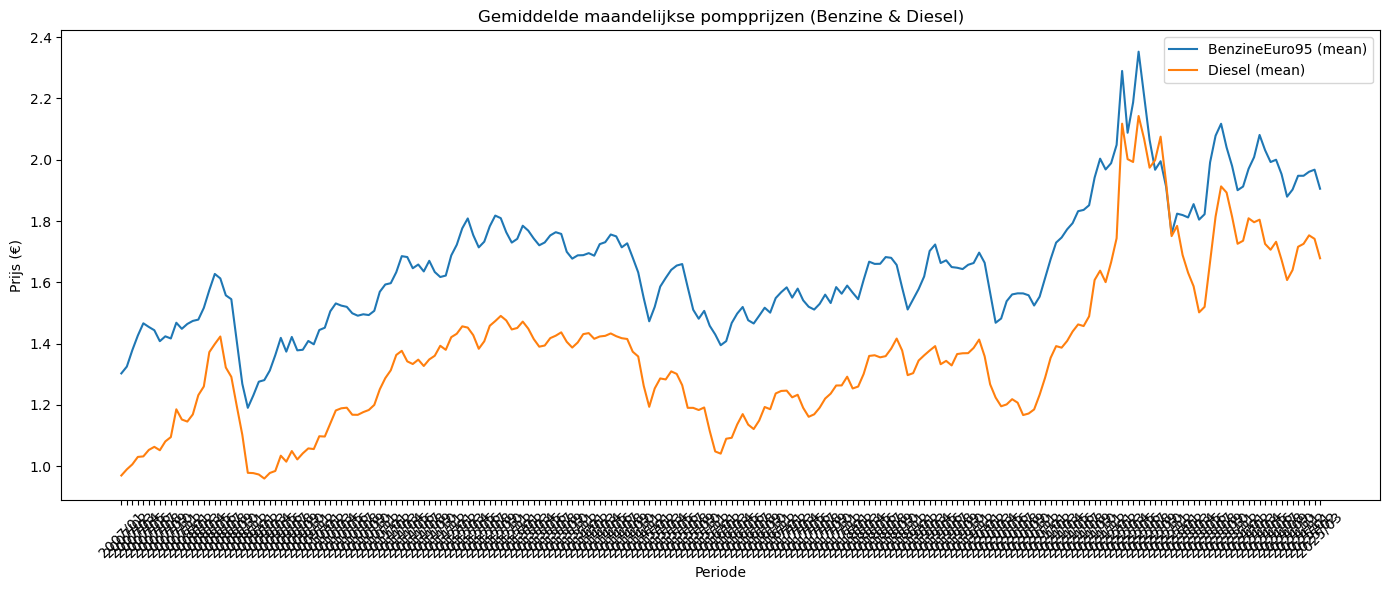

In [129]:
# Plot the monthly aggregated fuel prices for Benzine and Diesel
plt.figure(figsize=(14, 6))
plt.plot(df_pompprijzen_aggregatie['Periode'], df_pompprijzen_aggregatie['BenzineEuro95_1_mean'], label='BenzineEuro95 (mean)')
plt.plot(df_pompprijzen_aggregatie['Periode'], df_pompprijzen_aggregatie['Diesel_2_mean'], label='Diesel (mean)')
plt.xlabel('Periode')
plt.ylabel('Prijs (€)')
plt.title('Gemiddelde maandelijkse pompprijzen (Benzine & Diesel)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [151]:
# Controleer of alle maanden tussen 2007/01 en 2025/04 aanwezig zijn in df_consumenten_merged
verwachte_maanden = pd.date_range(start='2007-01-01', end='2025-04-01', freq='MS').strftime('%Y/%m')
ontbrekende_maanden = set(verwachte_maanden) - set(df_consumenten_merged['Periode'])

# Controleer op ontbrekende waarden (NaN's)
ontbrekende_waarden = df_consumenten_merged.isna().sum()

print("Ontbrekende maanden:", ontbrekende_maanden)
print("Ontbrekende waarden per kolom:\n", ontbrekende_waarden)

Ontbrekende maanden: set()
Ontbrekende waarden per kolom:
 Periode                  0
Consumentenvertrouwen    0
Economisch klimaat       0
Koopbereidheid           0
Grote aankopen           0
dtype: int64


 >Data opschonen 

-  perioden wijzigen naar yy/mm 
- datum selecteren 2015-1 t/m 2025-01

> - Perioden omzetten naar per maand (first, last, min, mean, avg voor benzine en diesel)

> Export CSV

In [152]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv"
df_pompprijzen_aggregatie.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv


> # BPM!

In [23]:
# Dataset 2 inladen
df_bijtelling_Raw = pd.read_csv(
    r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Usefull\Overheid\bijtelling_per_maand_2007_2025.csv"
    
   
)
display(df_bijtelling_Raw)

,Datum,Jaar,Maand,Bijtellingspercentage
0,2007-01-01,2007,1,0
1,2007-02-01,2007,2,0
2,2007-03-01,2007,3,0
3,2007-04-01,2007,4,0
4,2007-05-01,2007,5,0
...,...,...,...,...
223,2025-08-01,2025,8,17
224,2025-09-01,2025,9,17
225,2025-10-01,2025,10,17
226,2025-11-01,2025,11,17


In [140]:
# Zet 'Datum' om naar YYYY/MM formaat
df_bijtelling_Raw['Periode'] = pd.to_datetime(df_bijtelling_Raw['Datum']).dt.strftime('%Y/%m')

# Verwijder de kolommen 'Jaar' en 'Maand'
df_bijtelling_Raw.drop(['Jaar', 'Maand'], axis=1, inplace=True)

# Resultaat tonen
display(df_bijtelling_Raw.head())

,Datum,Bijtellingspercentage,Periode
0,2007-01-01,0,2007/01
1,2007-02-01,0,2007/02
2,2007-03-01,0,2007/03
3,2007-04-01,0,2007/04
4,2007-05-01,0,2007/05


In [141]:
# Sla alleen 'Periode' en 'Bijtellingspercentage' op als nieuwe CSV
bijtelling_output_path = r"E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage.csv"
df_bijtelling_Raw[['Periode', 'Bijtellingspercentage']].to_csv(bijtelling_output_path, index=False)
print(f"CSV opgeslagen op: {bijtelling_output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage.csv


Loading

In [18]:
df_wegvoertuigen = pd.read_csv(r"E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv", sep=",")
df_bijtelling_percentage = pd.read_csv(r"E:\Nieuw dataset\Bijtelling\bijtelling_periode_percentage.csv")
df_pompprijzen_aggregatie = pd.read_csv(r"E:\Nieuw dataset\CBS POMPPRIJZEN\df_pomprijzen_Nieuwaggregatie.csv", sep=",")
df_trends = pd.read_csv(r"E:\Nieuw dataset\Google trends\TopTrends_EV_Zoektermen_NL_2007heden.csv", sep=",")
df_consumentenvertrouwen_merged = pd.read_csv(
    r"E:\Nieuw dataset\Consumentenvertrouwen, economisch klimaat en koopbereidheid ongecorrigeerd\consumentenvertrouwen_2007_Merged.csv",
    sep=","
)



### Join both datasets on periode

In [19]:
# Join Google Trends, Wegvoertuigen, Bijtelling, Consumentenvertrouwen en Pompprijzen op 'Periode'
df_trends_wegvoertuigen = pd.merge(df_trends, df_wegvoertuigen, on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_bijtelling_percentage[['Periode', 'Bijtellingspercentage']], on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_consumentenvertrouwen_merged, on='Periode', how='left')
df_trends_wegvoertuigen = pd.merge(df_trends_wegvoertuigen, df_pompprijzen_aggregatie, on='Periode', how='left')

# Zet 'Totaal_verkochte_wegvoertuigen' als laatste kolom
kolommen = [col for col in df_trends_wegvoertuigen.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_trends_wegvoertuigen = df_trends_wegvoertuigen[kolommen]

# Resultaat bekijken
display(df_trends_wegvoertuigen)

# Controleer op ontbrekende waarden in de samengevoegde dataset
missing_values = df_trends_wegvoertuigen.isnull().sum()
print("Ontbrekende waarden per kolom:\n", missing_values)


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,0,20.00,37.0,9.00,8.00,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,0,20.00,37.0,9.00,8.00,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,0,20.00,37.0,9.00,8.00,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,0,20.00,37.0,9.00,8.00,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,0,18.00,32.0,9.00,7.40,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024/09,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,1.861,1.859,1.916,1.879633,1.635,1.589,1.584,1.640,1.607667,28820
213,2024/10,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,1.914,1.859,1.926,1.902806,1.588,1.649,1.587,1.660,1.640419,30491
214,2024/11,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,1.955,1.912,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167,32623
215,2024/12,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,1.942,1.940,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774,39594


Ontbrekende waarden per kolom:
 Periode                           0
thuis opladen                     0
elektrische auto                  0
hybride elektrisch                0
Bijtellingspercentage             0
Consumentenvertrouwen             0
Economisch klimaat                0
Koopbereidheid                    0
Grote aankopen                    0
BenzineEuro95_1_first             0
BenzineEuro95_1_last              0
BenzineEuro95_1_min               0
BenzineEuro95_1_max               0
BenzineEuro95_1_mean              0
Diesel_2_first                    0
Diesel_2_last                     0
Diesel_2_min                      0
Diesel_2_max                      0
Diesel_2_mean                     0
Totaal_verkochte_wegvoertuigen    0
dtype: int64


In [156]:
# Print all rows in df_trends_wegvoertuigen that contain any NaN values
nan_rows = df_trends_wegvoertuigen[df_trends_wegvoertuigen.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [Periode, EV: (Nederland), subsidie elektrische auto: (Nederland), elektrische auto: (Nederland), elektrisch rijden: (Nederland), Bijtellingspercentage, Consumentenvertrouwen, Economisch klimaat, Koopbereidheid, Grote aankopen, BenzineEuro95_1_first, BenzineEuro95_1_last, BenzineEuro95_1_min, BenzineEuro95_1_max, BenzineEuro95_1_mean, Diesel_2_first, Diesel_2_last, Diesel_2_min, Diesel_2_max, Diesel_2_mean, Totaal_verkochte_wegvoertuigen]
Index: []

[0 rows x 21 columns]


In [20]:
# Opslaan van df_trends_wegvoertuigen als CSV
output_joined_path = r"E:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv"
df_trends_wegvoertuigen.to_csv(output_joined_path, index=False)
print(f"CSV opgeslagen op: {output_joined_path}")

CSV opgeslagen op: E:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv


In [22]:
# Create a table with variable name, description, and datatype for df_trends_wegvoertuigen
variable_info = [
    ("Periode", "Period (YYYY/MM)", "str"),
    ("thuis opladen", "Google Trends score for 'thuis opladen' (charging at home)", "int"),
    ("elektrische auto", "Google Trends score for 'elektrische auto' (electric car)", "int"),
    ("hybride elektrisch", "Google Trends score for 'hybride elektrisch' (hybrid electric)", "int"),
    ("Bijtellingspercentage", "Addition percentage for company car tax", "int"),
    ("Consumentenvertrouwen", "Consumer confidence index", "float"),
    ("Economisch klimaat", "Economic climate index", "float"),
    ("Koopbereidheid", "Willingness to buy index", "float"),
    ("Grote aankopen", "Favorable time for large purchases index", "float"),
    ("BenzineEuro95_1_first", "First recorded price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_last", "Last recorded price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_min", "Minimum price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_max", "Maximum price of Euro95 gasoline in month", "float"),
    ("BenzineEuro95_1_mean", "Mean price of Euro95 gasoline in month", "float"),
    ("Diesel_2_first", "First recorded price of Diesel in month", "float"),
    ("Diesel_2_last", "Last recorded price of Diesel in month", "float"),
    ("Diesel_2_min", "Minimum price of Diesel in month", "float"),
    ("Diesel_2_max", "Maximum price of Diesel in month", "float"),
    ("Diesel_2_mean", "Mean price of Diesel in month", "float"),
    ("Totaal_verkochte_wegvoertuigen", "Total number of sold vehicles (all types)", "int"),
]

df_variable_info = pd.DataFrame(variable_info, columns=["Variable Name", "Description", "Data Type"])
display(df_variable_info)

,Variable Name,Description,Data Type
0,Periode,Period (YYYY/MM),str
1,thuis opladen,Google Trends score for 'thuis opladen' (charg...,int
2,elektrische auto,Google Trends score for 'elektrische auto' (el...,int
3,hybride elektrisch,Google Trends score for 'hybride elektrisch' (...,int
4,Bijtellingspercentage,Addition percentage for company car tax,int
5,Consumentenvertrouwen,Consumer confidence index,float
6,Economisch klimaat,Economic climate index,float
7,Koopbereidheid,Willingness to buy index,float
8,Grote aankopen,Favorable time for large purchases index,float
9,BenzineEuro95_1_first,First recorded price of Euro95 gasoline in month,float


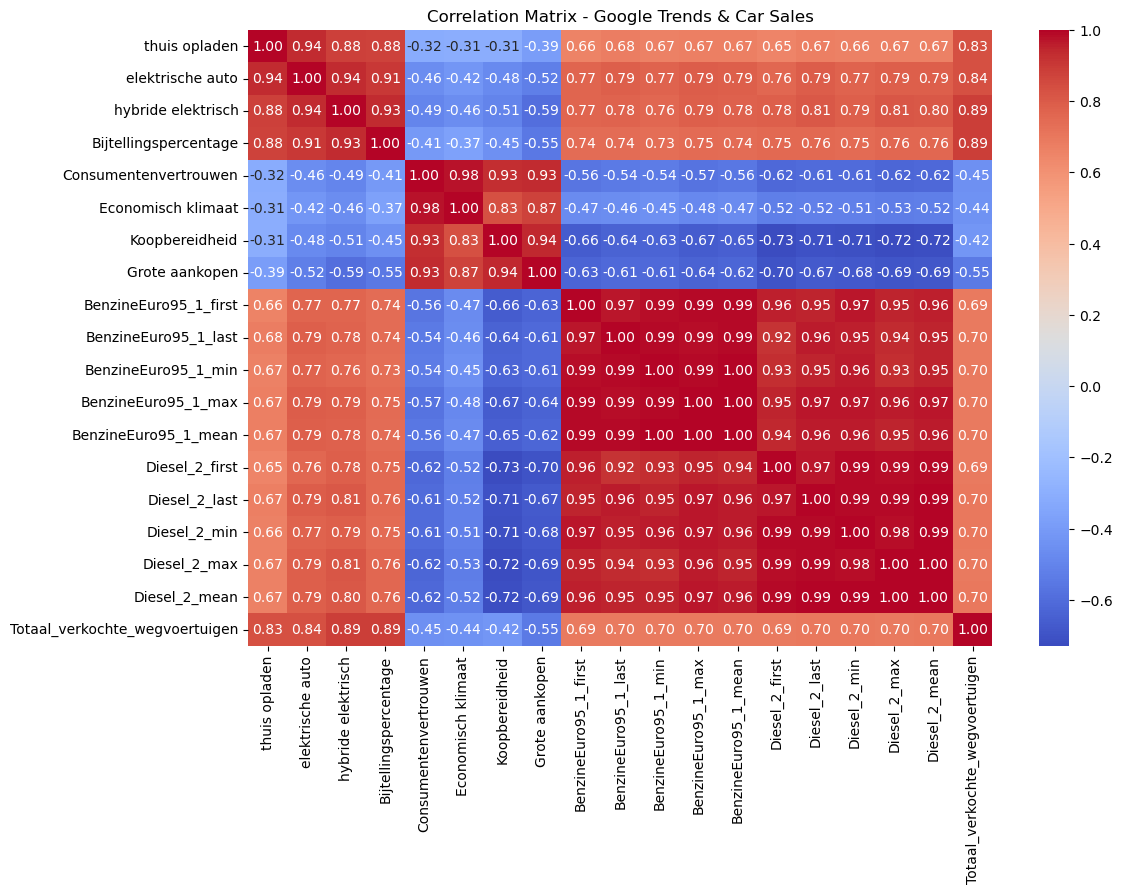

ValueError: Could not interpret value `EV: (Nederland)` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [ ]:
# Correlation matrix plot (exclude non-numeric columns)
plt.figure(figsize=(12, 8))
corr = df_trends_wegvoertuigen.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Google Trends & Car Sales')
plt.show()

# Scatter plot: EV search interest vs. car sales
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_trends_wegvoertuigen,
    x='EV: (Nederland)',
    y='Totaal_verkochte_wegvoertuigen'
)
# plt.xlabel('Google Trends: EV (Nederland)')
# plt.ylabel('Totaal verkochte wegvoertuigen')
# plt.title('EV Search Interest vs. Car Sales')
# plt.show()

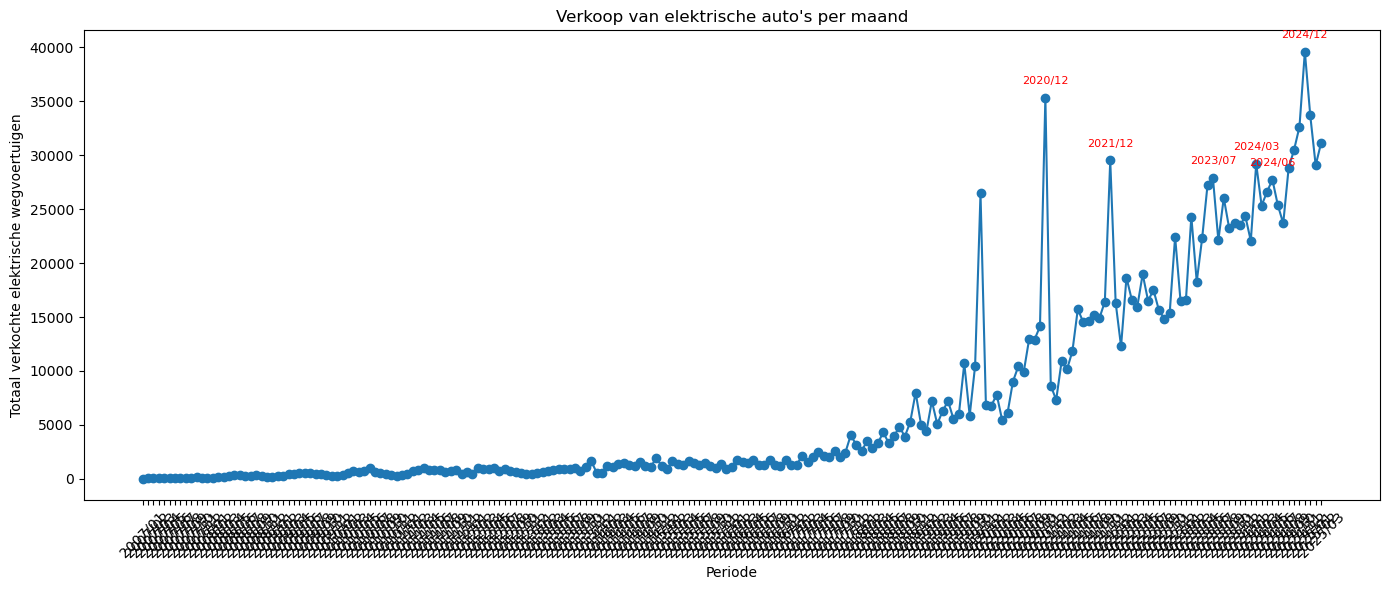

In [123]:
from scipy.signal import find_peaks  # Import the find_peaks function for peak detection

plt.figure(figsize=(14, 6))  # Create a new figure with a specific size
plt.plot(df_wegvoertuigen['Periode'], df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'], marker='o')  # Plot sales per period
plt.xlabel('Periode')  # Set x-axis label
plt.ylabel('Totaal verkochte elektrische wegvoertuigen')  # Set y-axis label
plt.title('Verkoop van elektrische auto\'s per maand')  # Set plot title
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Pieken bepalen (lokaal maximum)
peaks, _ = find_peaks(df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'])  # Find indices of local maxima (peaks)

# Top 5 spikes (op basis van hoogte)
top5_idx = np.argsort(df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'].iloc[peaks])[-6:]  # Get indices of 6 highest peaks
top5_peaks = peaks[top5_idx]  # Get the actual peak positions for the top 6

for peak in top5_peaks:  # Loop over each top peak
    plt.annotate(
        df_wegvoertuigen['Periode'].iloc[peak],  # Annotate with the period (month/year)
        (df_wegvoertuigen['Periode'].iloc[peak], df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'].iloc[peak]),  # At the peak's coordinates
        textcoords="offset points",  # Offset the text from the point
        xytext=(0,10),  # Offset by 10 points above
        ha='center',  # Center the annotation horizontally
        fontsize=8,  # Set font size
        color='red'  # Set annotation color to red
    )
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

## Lag 
12 month lag time


In [74]:
df = df_trends_wegvoertuigen.copy()
df['Periode'] = pd.to_datetime(df['Periode'], format='%Y-%m-%d')
df = df.sort_values('Periode').reset_index(drop=True)

# Define lag settings
sales_lag = 2
google_lag = 0

# Define columns
target_cols = ['Totaal_verkochte_wegvoertuigen']
google_trend_cols = ['thuis opladen', 'elektrische auto', 'hybride elektrisch']

# Apply lag for car sales (6 months)
for col in target_cols:
    for lag in range(1, sales_lag + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Apply lag for Google Trends (4 months)
for col in google_trend_cols:
    for lag in range(1, google_lag + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Drop rows with NaNs
df_lagged = df.dropna().reset_index(drop=True)


display(df_lagged)


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen,Totaal_verkochte_wegvoertuigen_lag1,Totaal_verkochte_wegvoertuigen_lag2
0,2007-03-01,0,0,0,0,20.00,37.0,9.00,8.00,1.365,...,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123,39.0,31.0
1,2007-04-01,0,0,0,0,20.00,37.0,9.00,8.00,1.414,...,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62,123.0,39.0
2,2007-05-01,0,2,0,0,18.00,32.0,9.00,7.40,1.452,...,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84,62.0,123.0
3,2007-06-01,0,2,0,0,16.00,27.0,9.00,6.80,1.458,...,1.461,1.454600,1.035,1.057,1.035,1.066,1.053433,112,84.0,62.0
4,2007-07-01,0,1,0,0,14.00,22.0,9.00,6.20,1.451,...,1.469,1.443903,1.057,1.064,1.057,1.069,1.063484,124,112.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2024-09-01,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,...,1.916,1.879633,1.635,1.589,1.584,1.640,1.607667,28820,23683.0,25370.0
211,2024-10-01,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,...,1.926,1.902806,1.588,1.649,1.587,1.660,1.640419,30491,28820.0,23683.0
212,2024-11-01,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,...,1.986,1.947800,1.652,1.744,1.648,1.774,1.716167,32623,30491.0,28820.0
213,2024-12-01,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,...,1.958,1.947871,1.740,1.720,1.716,1.748,1.725774,39594,32623.0,30491.0


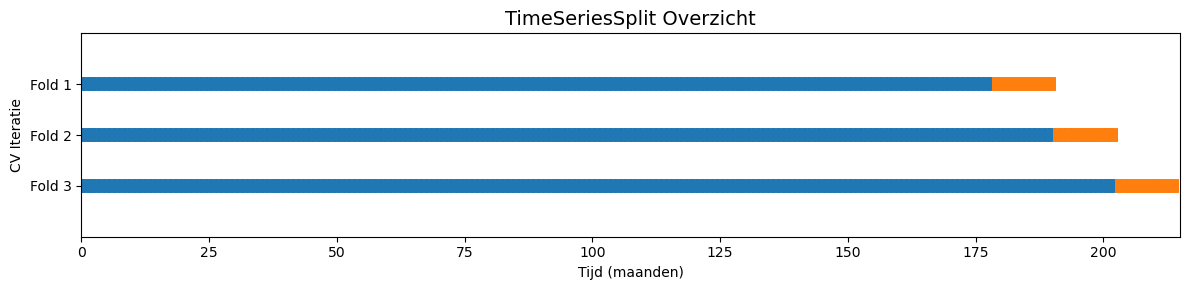

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.colors as mcolors

# --- Load your data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)
X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- Define TimeSeriesSplit ---
n_splits = 3
test_size = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# --- Custom color map for CV ---
cmap_cv = mcolors.ListedColormap(["#1f77b4", "#ff7f0e"])  # Blue for train, Orange for test

# --- Plot function ---
def plot_cv_indices(cv, X, y, ax, lw=10):
    for ii, (train_index, test_index) in enumerate(cv.split(X=X)):
        indices = np.full(len(X), np.nan)
        indices[train_index] = 0
        indices[test_index] = 1

        ax.scatter(
            range(len(X)),
            [ii + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=[f"Fold {i+1}" for i in range(n_splits)],
        xlabel="Tijd (maanden)",
        ylabel="CV Iteratie",
        ylim=[n_splits + 0.5, -0.5],
        xlim=[0, len(X)],
    )
    ax.set_title("TimeSeriesSplit Overzicht", fontsize=14)

# --- Run and plot ---
fig, ax = plt.subplots(figsize=(12, 3))
plot_cv_indices(tscv, X, y, ax)
plt.tight_layout()
plt.show()


### Arima 


Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-04-01
RMSE: 2984.93
MAE: 2340.65
MAPE / Foutmarge (%): 17.27


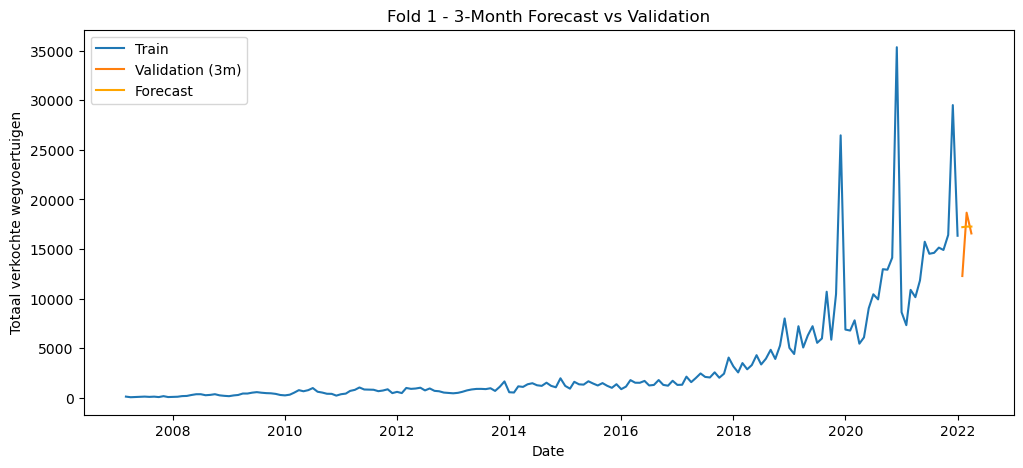


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-04-01
RMSE: 4162.09
MAE: 2917.66
MAPE / Foutmarge (%): 12.85


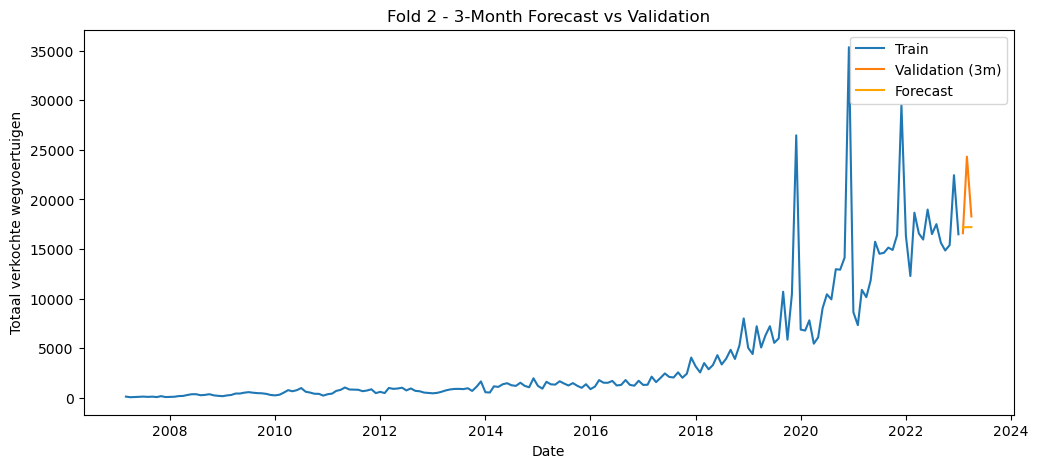


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-04-01
RMSE: 3468.77
MAE: 2946.26
MAPE / Foutmarge (%): 10.99


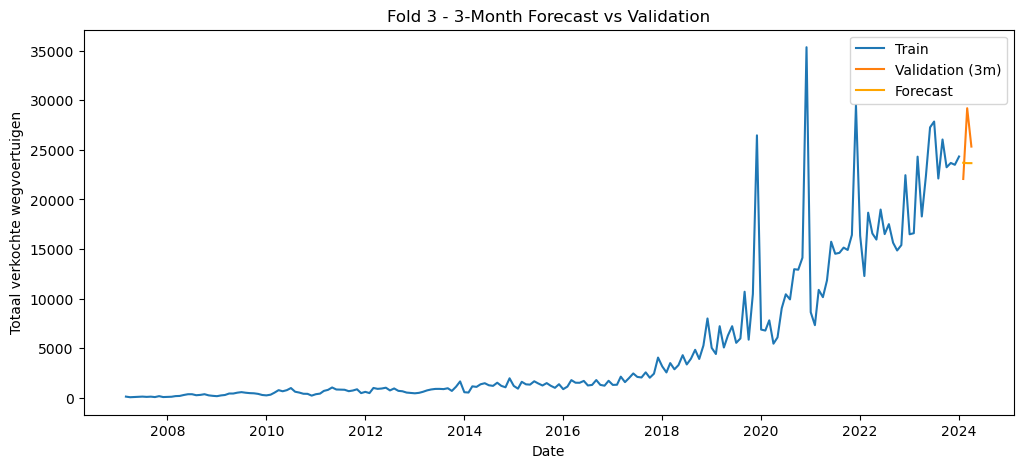


🔚 Gemiddelde prestaties over alle folds:
Gemiddelde RMSE: 3538.60
Gemiddelde MAE: 2734.86
Gemiddelde MAPE / Foutmarge (%): 13.70


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Target only
y = df['Totaal_verkochte_wegvoertuigen']
forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores = [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100  # In percentage

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1):%Y-%m-%d}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Foutmarge (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Totaal verkochte wegvoertuigen')
    plt.legend()
    plt.show()

# Print averages
print("\n🔚 Gemiddelde prestaties over alle folds:")
print(f"Gemiddelde RMSE: {np.mean(rmse_scores):.2f}")
print(f"Gemiddelde MAE: {np.mean(mae_scores):.2f}")
print(f"Gemiddelde MAPE / Foutmarge (%): {np.mean(mape_scores):.2f}")



📌 Evaluating WITHOUT feature: thuis opladen

📌 Evaluating WITHOUT feature: elektrische auto

📌 Evaluating WITHOUT feature: hybride elektrisch

📌 Evaluating WITHOUT feature: Bijtellingspercentage


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\s


📌 Evaluating WITHOUT feature: Consumentenvertrouwen


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📌 Evaluating WITHOUT feature: Economisch klimaat

📌 Evaluating WITHOUT feature: Koopbereidheid

📌 Evaluating WITHOUT feature: Grote aankopen

📌 Evaluating WITHOUT feature: BenzineEuro95_1_first

📌 Evaluating WITHOUT feature: BenzineEuro95_1_last

📌 Evaluating WITHOUT feature: BenzineEuro95_1_min

📌 Evaluating WITHOUT feature: BenzineEuro95_1_max

📌 Evaluating WITHOUT feature: BenzineEuro95_1_mean

📌 Evaluating WITHOUT feature: Diesel_2_first

📌 Evaluating WITHOUT feature: Diesel_2_last

📌 Evaluating WITHOUT feature: Diesel_2_min

📌 Evaluating WITHOUT feature: Diesel_2_max

📌 Evaluating WITHOUT feature: Diesel_2_mean

📌 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag1

📌 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag2


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔎 LOFO resultaten (gesorteerd op laagste RMSE):
                       Feature_left_out     Avg_RMSE      Avg_MAE  \
6                        Koopbereidheid  2212.409748  1782.601600   
18  Totaal_verkochte_wegvoertuigen_lag1  2422.869408  1860.193441   
19  Totaal_verkochte_wegvoertuigen_lag2  2627.994077  1932.428853   
1                      elektrische auto  2709.613497  2398.224269   
14                        Diesel_2_last  2887.671324  2369.600927   
15                         Diesel_2_min  2895.408279  2428.803248   
2                    hybride elektrisch  2898.826021  2361.000179   
11                  BenzineEuro95_1_max  2903.630157  2364.394293   
16                         Diesel_2_max  2905.810092  2377.342523   
13                       Diesel_2_first  2914.720396  2453.577249   
17                        Diesel_2_mean  2952.907020  2456.043112   
0                         thuis opladen  2989.429925  2489.145603   
7                        Grote aankopen  3028.756823  

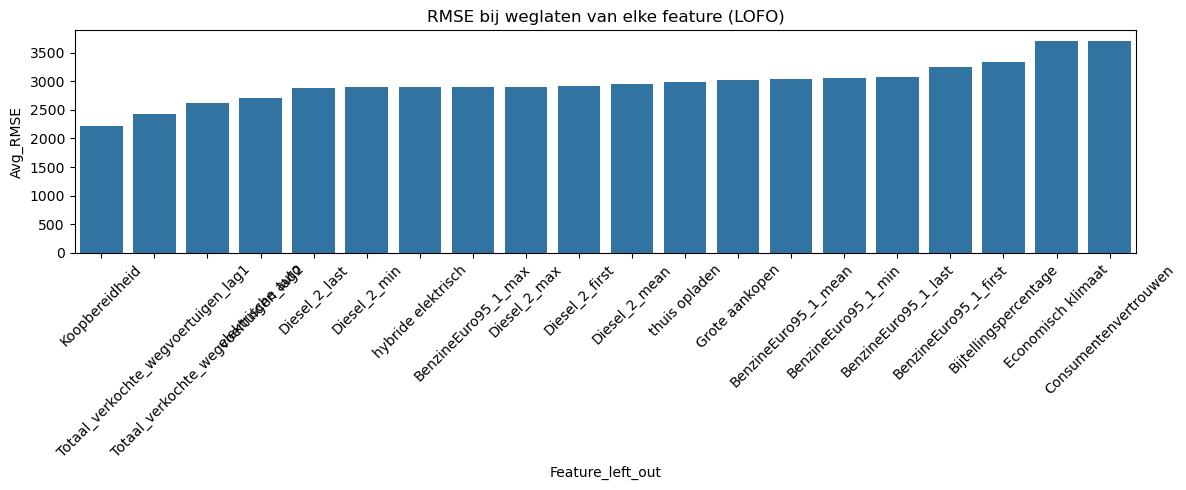

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

target_column = 'Totaal_verkochte_wegvoertuigen'
all_feature_columns = [col for col in df.columns if col not in ['Periode', target_column]]

forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

results = []

for feature_to_leave_out in all_feature_columns:
    print(f"\n📌 Evaluating WITHOUT feature: {feature_to_leave_out}")
    feature_columns = [col for col in all_feature_columns if col != feature_to_leave_out]

    X = df[feature_columns]
    y = df[target_column]

    rmse_scores, mae_scores, mape_scores = [], [], []

    for i, (train_index, val_index) in enumerate(tscv.split(y)):
        y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
        X_train, X_val_full = X.iloc[train_index], X.iloc[val_index]

        y_val = y_val_full.iloc[:forecast_horizon]
        X_val = X_val_full.iloc[:forecast_horizon]

        # Fit SARIMAX
        model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

        rmse = np.sqrt(mean_squared_error(y_val, forecast))
        mae = mean_absolute_error(y_val, forecast)
        mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Store average results for this feature exclusion
    results.append({
        'Feature_left_out': feature_to_leave_out,
        'Avg_RMSE': np.mean(rmse_scores),
        'Avg_MAE': np.mean(mae_scores),
        'Avg_MAPE (%)': np.mean(mape_scores)
    })

# Show all results in a DataFrame
results_df = pd.DataFrame(results).sort_values('Avg_RMSE')
import seaborn as sns

print("\n🔎 LOFO resultaten (gesorteerd op laagste RMSE):")
print(results_df)

# Optional: Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x='Feature_left_out', y='Avg_RMSE')
plt.xticks(rotation=45)
plt.title('RMSE bij weglaten van elke feature (LOFO)')
plt.tight_layout()
plt.show()



Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-04-01
RMSE: 4033.66
MAE: 3779.86
MAPE / Foutmarge (%): 23.01


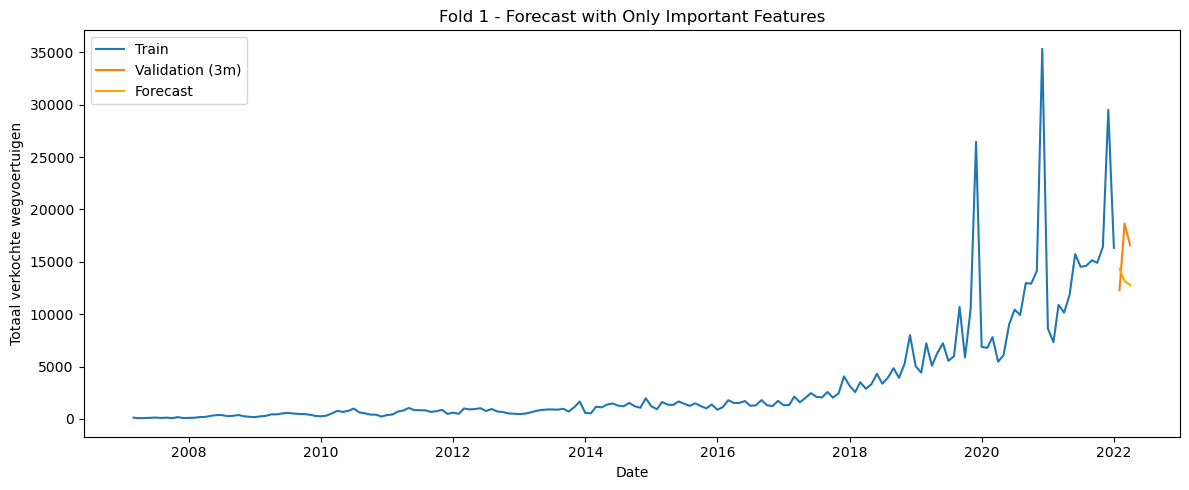


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-04-01
RMSE: 3416.73
MAE: 2721.32
MAPE / Foutmarge (%): 12.63


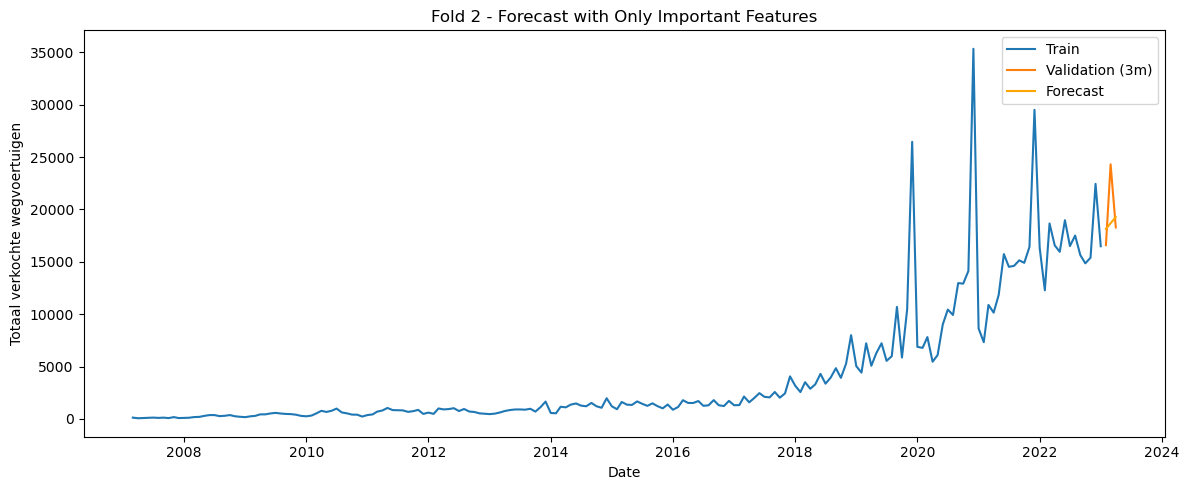


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-04-01
RMSE: 2745.86
MAE: 2335.30
MAPE / Foutmarge (%): 9.07


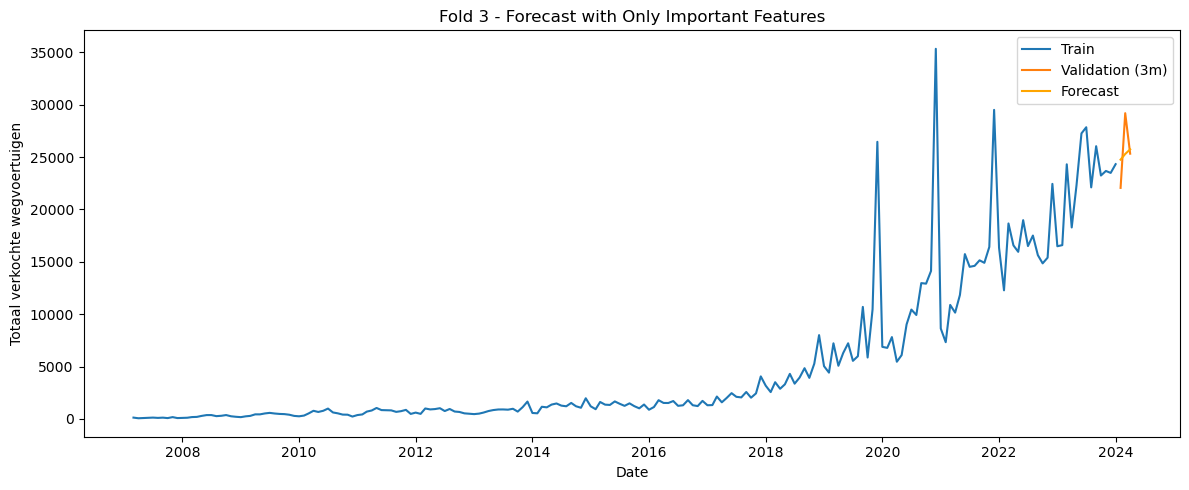


📊 Gemiddelde prestaties met alleen belangrijke features:
Gemiddelde RMSE: 3398.75
Gemiddelde MAE: 2945.49
Gemiddelde MAPE / Foutmarge (%): 14.90


In [79]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set your important features
important_features = [
    'Consumentenvertrouwen',
    'Economisch klimaat',
    'Bijtellingspercentage',
    'BenzineEuro95_1_first',
    'BenzineEuro95_1_last'
]

# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

target_column = 'Totaal_verkochte_wegvoertuigen'
X = df[important_features]
y = df[target_column]

forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Store metrics
rmse_scores, mae_scores, mape_scores = [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    X_train, X_val_full = X.iloc[train_index], X.iloc[val_index]

    y_val = y_val_full.iloc[:forecast_horizon]
    X_val = X_val_full.iloc[:forecast_horizon]

    # Fit SARIMAX
    model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    # Output per fold
    print(f"\nFold {i + 1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1):%Y-%m-%d}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Foutmarge (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - Forecast with Only Important Features')
    plt.xlabel('Date')
    plt.ylabel('Totaal verkochte wegvoertuigen')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Summary
print("\n📊 Gemiddelde prestaties met alleen belangrijke features:")
print(f"Gemiddelde RMSE: {np.mean(rmse_scores):.2f}")
print(f"Gemiddelde MAE: {np.mean(mae_scores):.2f}")
print(f"Gemiddelde MAPE / Foutmarge (%): {np.mean(mape_scores):.2f}")


### XGBOOST


In [77]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Use the in-memory lagged DataFrame
df = df_lagged
target_column = 'Totaal_verkochte_wegvoertuigen'


# Prepare features and target
X = df.drop(columns=[target_column, 'Periode'])
y = df[target_column]

# TimeSeriesSplit configuration
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

# Store results
train_mae_scores = []
test_mae_scores = []

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {i + 1}: Training model...")

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Define and fit XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        max_depth=3,           # Reduce depth
        learning_rate=0.05,    # Smoother learning
        subsample=0.8,         # Random rows per tree
        colsample_bytree=0.8,  # Random columns per tree
        reg_alpha=10,          # L1 regularization
        reg_lambda=1,          # L2 regularization
        random_state=42,
        eval_metric='mae'
    )
    model.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)

    print(f"Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")
    print("Last 3 test predictions:")
    for actual, pred in zip(y_test.tail(3), y_test_pred[-3:]):
        print(f"  Actual: {actual:.0f}, Predicted: {pred:.0f}")

# Summary
print("\n--- Cross-Validation Summary ---")
print(f"Average Train MAE: {sum(train_mae_scores) / len(train_mae_scores):.2f}")
print(f"Average Test MAE:  {sum(test_mae_scores) / len(test_mae_scores):.2f}")





Fold 1: Training model...
Train MAE: 26.01 | Test MAE: 4903.80
Last 3 test predictions:
  Actual: 14125, Predicted: 6183
  Actual: 35341, Predicted: 7123
  Actual: 8633, Predicted: 7258

Fold 2: Training model...
Train MAE: 35.55 | Test MAE: 4824.49
Last 3 test predictions:
  Actual: 16421, Predicted: 18747
  Actual: 29509, Predicted: 11923
  Actual: 16338, Predicted: 14304

Fold 3: Training model...
Train MAE: 41.29 | Test MAE: 2385.47
Last 3 test predictions:
  Actual: 15395, Predicted: 19085
  Actual: 22443, Predicted: 19752
  Actual: 16487, Predicted: 16007

Fold 4: Training model...
Train MAE: 59.76 | Test MAE: 7325.63
Last 3 test predictions:
  Actual: 23676, Predicted: 15747
  Actual: 23490, Predicted: 19076
  Actual: 24325, Predicted: 18789

Fold 5: Training model...
Train MAE: 80.55 | Test MAE: 10063.17
Last 3 test predictions:
  Actual: 32623, Predicted: 20708
  Actual: 39594, Predicted: 18516
  Actual: 33680, Predicted: 18507

--- Cross-Validation Summary ---
Average Train 

In [61]:
def walk_forward_lagged(df, target_col='Totaal_verkochte_wegvoertuigen'):
    feature_cols = [col for col in df.columns if col not in ['Periode', target_col]]
    
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx].copy()
    df_val = df.iloc[split_idx:].copy()

    predictions = []
    actuals = []
    
    for i in range(len(df_val)):
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
        
        X_train = df_train[feature_cols].values
        y_train = df_train[target_col].values
        model.fit(X_train, y_train)

        current_row = df_val.iloc[i:i+1]
        X_val = current_row[feature_cols].values
        y_val = current_row[target_col]

        y_pred = model.predict(X_val)[0]

        predictions.append(y_pred)
        actuals.append(y_val.values[0])
        
        # Add the current validation row to training set for next step
        df_train = pd.concat([df_train, current_row], ignore_index=True)

    mae = mean_absolute_error(actuals, predictions)
    print(f"Overall walk-forward MAE: {mae:.2f}")
    return predictions, actuals

predictions, actuals = walk_forward_lagged(df_lagged)

Overall walk-forward MAE: 4184.36


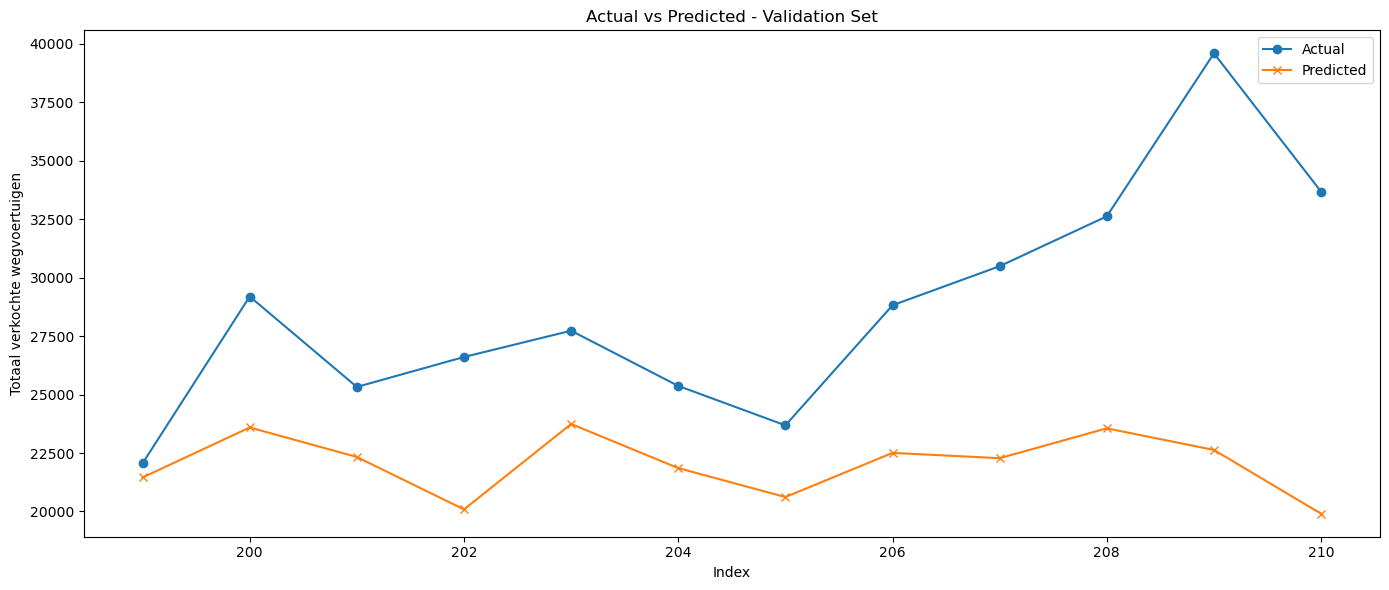

In [62]:
# Plot actual vs predicted values for the validation (test) set
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.title('Actual vs Predicted - Validation Set')
plt.legend()
plt.tight_layout()
plt.show()